# AVTP Intrusion Dataset Data Handler Notebook

This notebook takes the raw input from AVTP Intrusion Dataset, aggregate and label it following the specified parameters

## Mount google drive

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dependencies

In [ ]:
# Install library
!pip install scapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Libraries

In [ ]:
# Libraries

import gc # garbage collector
import pandas as pd
import numpy as np
from scapy.all import *

### Helper functions

In [ ]:
# Helper functions
def __read_raw_packets(pcap_filepath):
  raw_packets = rdpcap(pcap_filepath)

  raw_packets_list = []

  for packet in raw_packets:
    if (len(packet) == 438): # The length of AVTP packets in 438 bytes
      raw_packets_list.append(raw(packet))

  return raw_packets_list


def __convert_raw_packets(raw_packets_list):
  converted_packets_list = []

  for raw_packet in raw_packets_list:
    converted_packet = np.frombuffer(raw_packet, dtype='uint8')
    converted_packets_list.append(converted_packet)

  return np.array(converted_packets_list, dtype='uint8')


def __is_array_in_list_of_arrays(array_to_check, list_np_arrays):
  # Reference:
  # https://stackoverflow.com/questions/23979146/check-if-numpy-array-is-in-list-of-numpy-arrays
  is_in_list = np.any(np.all(array_to_check == list_np_arrays, axis=1))

  return is_in_list


def __generate_labels(packets_list, injected_packets):
  labels_list = []

  for packet in packets_list:
    current_label = 0

    if __is_array_in_list_of_arrays(packet, injected_packets):
      current_label = 1

    labels_list.append(current_label)

  return labels_list


def __select_packets_bytes(packets_list, first_byte=0, last_byte=58):
  selected_packets = packets_list[:, first_byte:last_byte]

  return np.array(selected_packets, dtype='uint8')


def __calculate_difference_module(selected_packets):
  difference_array = np.diff(selected_packets, axis=0)
  difference_module = np.mod(difference_array, 256)

  return difference_module


def __split_byte_into_nibbles(byte):
  high_nibble = (byte >> 4) & 0xf
  low_nibble = (byte) & 0xf

  return high_nibble, low_nibble


def __create_nibbles_matrix(difference_module):
  nibbles_matrix = []

  # difference matrix é uma matriz com n linhas e p colunas
  for row_index in range(len(difference_module)):
    nibbles_row = []
    for column_index in range(len(difference_module[row_index])):
      hi_ni, low_ni = __split_byte_into_nibbles(difference_module[row_index, column_index])

      nibbles_row.append(hi_ni)
      nibbles_row.append(low_ni)

    nibbles_matrix.append(np.array(nibbles_row, dtype='uint8'))

  return np.array(nibbles_matrix, dtype='uint8')

def preprocess_raw_packets(converted_packets, split_into_nibbles=True):
  # select first 58 bytes
  selected_packets = __select_packets_bytes(converted_packets)

  # calculate difference and module between rows
  diff_module_packets = __calculate_difference_module(selected_packets)

  # split difference into two nibbles
  if split_into_nibbles:
    diff_module_packets = __create_nibbles_matrix(diff_module_packets)

  return diff_module_packets

def aggregate_based_on_window_size(x_data, y_data, window_size=44, window_slide=44):
    # Prepare the list for the transformed data
    X, y = list(), list()

    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        start_ix = i*(window_slide)
        end_ix = start_ix + window_size - 1 + 1

        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break

        # Get a sequence of data for x
        seq_X = x_data[start_ix:end_ix]
        if (window_slide == 1):
          # Get only the last element of the sequence for y
          seq_y = y_data[end_ix]
        else:
          # If the sequence contains an attack, the label is considered as attack
          tmp_seq_y = y_data[start_ix:end_ix]
          if 1 in tmp_seq_y:
            seq_y = 1
          else:
            seq_y = 0
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X, dtype='uint8')
    y_array = np.array(y, dtype='uint8')

    return x_array, y_array

## Main code

In [ ]:
# filepaths
drive_root_path = "/content/drive/MyDrive/AVTP dataset"

# indoors injected files
injected_raw_packets_filepaths = ["indoors_01_injected.pcap", "indoors_02_injected.pcap"]

## injected only
single_MPEG_frame_fp = f"{drive_root_path}/single-MPEG-frame.pcap"

WINDOW_SIZE = 44
NUMBER_OF_BYTES = 58
NUMBER_OF_COLUMNS = NUMBER_OF_BYTES * 2

# treatment for injected packets
raw_injected_packet = __read_raw_packets(single_MPEG_frame_fp)
injected_packet_array = __convert_raw_packets(raw_injected_packet)

X = np.empty(shape=(0, WINDOW_SIZE, NUMBER_OF_COLUMNS), dtype='uint8')
y = np.array([], dtype='uint8')

for injected_paw_packets_fp in injected_raw_packets_filepaths:
  # load raw packets
  raw_packets = __read_raw_packets(f"{drive_root_path}/{injected_paw_packets_fp}")
  # convert loaded packets to np array with uint8_t size
  packets_array = __convert_raw_packets(raw_packets)
  # preprocess packets
  preprocessed_packets = preprocess_raw_packets(packets_array, split_into_nibbles=True)
  # generate labels
  labels = __generate_labels(packets_array, injected_packet_array)
  # aggregate features and labels
  aggregated_X, aggregated_y = aggregate_based_on_window_size(preprocessed_packets, labels, window_size=WINDOW_SIZE, window_slide=1)

  # concatenate both indoors injected packets
  X = np.concatenate((X, aggregated_X), axis=0, dtype='uint8')
  y = np.concatenate((y, aggregated_y), axis=0, dtype='uint8')

In [ ]:
single_MPEG_frame_fp = f"{drive_root_path}/single-MPEG-frame.pcap"
# treatment for injected packets
raw_injected_packet = __read_raw_packets(single_MPEG_frame_fp)
injected_packet_array = __convert_raw_packets(raw_injected_packet)

In [ ]:
injected_packet_array

array([[145, 224, 240, ...,  64, 156, 185],
       [145, 224, 240, ..., 196,  64,  43],
       [145, 224, 240, ...,  54,  80, 127],
       ...,
       [145, 224, 240, ..., 247, 227, 163],
       [145, 224, 240, ...,  38, 137, 196],
       [145, 224, 240, ..., 226, 207, 242]], dtype=uint8)

## Check dataset samples and distribution

In [ ]:
# Checking if dataset was properly labeled

indoors_unique, indoors_counts = np.unique(np.array(y), return_counts=True)

# Dindoors has 446,372 bening Xis and 196,894 injected Xis [Paper information]
print(f"Dindoors has {indoors_counts[0]} bening Xis and {indoors_counts[1]} injected Xis")

Dindoors has 446372 bening Xis and 196892 injected Xis


## Export data as npz files

In [ ]:
drive_root_path = "/content/drive/MyDrive/AVTP dataset"

np.savez(f"{drive_root_path}/x_indoors_agg_wsize_{WINDOW_SIZE}_cols_{NUMBER_OF_COLUMNS}", X)
np.savez(f"{drive_root_path}/y_indoors_agg_wisze_{WINDOW_SIZE}_cols_{NUMBER_OF_COLUMNS}", y)

## Exploratory analysis

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold

def load_train_validation_data(drive_root_path: str = "/content/drive/MyDrive/AVTP dataset", window_size=40, n_cols=58):
  X_path = f'{drive_root_path}/x_indoors_agg_wsize_{window_size}_cols_{n_cols}.npz'
  y_path = f'{drive_root_path}/y_indoors_agg_wsize_{window_size}_cols_{n_cols}.npz'

  X_indoors = np.load(X_path)
  X_indoors = np.array(X_indoors.f.arr_0, dtype='uint8')
  X_indoors = X_indoors.reshape((X_indoors.shape[0], -1, window_size, n_cols))


  y_indoors = np.load(y_path)
  y_indoors = np.array(y_indoors.f.arr_0, dtype='uint8')

  return X_indoors, y_indoors

def merge_train_data(X_indoors, y_indoors):
  # Combine features and labels
  # Only necessary for pytorch dataloader
  train_data = [[X_indoors[i], y_indoors[i]] for i in range(X_indoors.shape[0])]

  return train_data


def get_skf_dictionary(X_indoors, y_indoors):
  splitter_dict = {"0":
                  {
                      "train_idx": [],
                      "train_idx_normal": [],
                      "test_idx": [],
                   },
                 "1":
                  {
                      "train_idx": [],
                      "train_idx_normal": [],
                      "test_idx": []
                   },
                 "2":
                  {
                      "train_idx": [],
                      "train_idx_normal": [],
                      "test_idx": []
                   },
                 "3":
                  {
                      "train_idx": [],
                      "train_idx_normal": [],
                      "test_idx": []
                   },
                 "4":
                  {
                      "train_idx": [],
                      "train_idx_normal": [],
                      "test_idx": []
                   }
                 }
  skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
  skf.split(X_indoors, y_indoors)

  for fold,(train_idx,test_idx) in enumerate(skf.split(X_indoors, y_indoors)):
    print('------------fold no---------{}----------------------'.format(fold))

    train_y = y_indoors[train_idx]
    unique_train_y, count_train_y = np.unique(train_y, return_counts=True)
    print(f"unique_train_y = {unique_train_y}, count_train_y = {count_train_y}")
    train_y_normal = train_y == 0

    train_normal_idx = train_idx[train_y_normal]
    y_normal = y_indoors[train_normal_idx]
    unique, count = np.unique(y_normal, return_counts=True)
    print(f"unique = {unique}, count = {count}")

    print(f"train_idx = {train_idx}, train_idx_normal = {train_normal_idx}, test_idx = {test_idx}")
    splitter_dict[str(fold)]["train_idx"].extend(train_idx)
    splitter_dict[str(fold)]["train_idx_normal"].extend(train_normal_idx)
    splitter_dict[str(fold)]["test_idx"].extend(test_idx)

  return splitter_dict

In [ ]:
drive_root_path = "/content/drive/MyDrive/AVTP dataset"
WINDOW_SIZE=44
N_COLS=116
# WINDOW_SIZE=44
# N_COLS=116

X, y = load_train_validation_data(window_size=WINDOW_SIZE, n_cols=N_COLS)
train_data = merge_train_data(X, y)
splitter_dict = get_skf_dictionary(X, y)

------------fold no---------0----------------------
unique_train_y = [0 1], count_train_y = [357097 157514]
unique = [0], count = [357097]
train_idx = [     0      1      2 ... 643261 643262 643263], train_idx_normal = [     0      1      2 ... 640660 640661 640662], test_idx = [    16     18     23 ... 643253 643259 643260]
------------fold no---------1----------------------
unique_train_y = [0 1], count_train_y = [357097 157514]
unique = [0], count = [357097]
train_idx = [     0      1      2 ... 643261 643262 643263], train_idx_normal = [     0      1      2 ... 640659 640660 640661], test_idx = [     6     10     15 ... 643251 643254 643257]
------------fold no---------2----------------------
unique_train_y = [0 1], count_train_y = [357098 157513]
unique = [0], count = [357098]
train_idx = [     0      1      4 ... 643260 643261 643262], train_idx_normal = [     0      1      4 ... 640659 640660 640662], test_idx = [     2      3      8 ... 643255 643258 643263]
------------fold no

In [ ]:
fold_0_X_normal_train = X[splitter_dict["0"]["train_idx_normal"]]
fold_0_y_normal_train = y[splitter_dict["0"]["train_idx_normal"]]
fold_0_y_test = y[splitter_dict["0"]["test_idx"]]
fold_0_y_test_anomalies = fold_0_y_test == 1
fold_0_X_test_anomalies = X[splitter_dict["0"]["test_idx"]][fold_0_y_test_anomalies]

In [ ]:
import matplotlib.pyplot as plt

def plot_images(samples, n_rows=4, n_cols=4, shape=(40, 58)):
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

  selected_X = samples[0:n_rows*n_cols]
  X_index = 0

  for row in ax:
      for col in row:
          col.imshow(selected_X[X_index].reshape(shape[0], shape[1]))
          X_index = X_index + 1

  plt.show()

## Window_size = 40, N_cols=58

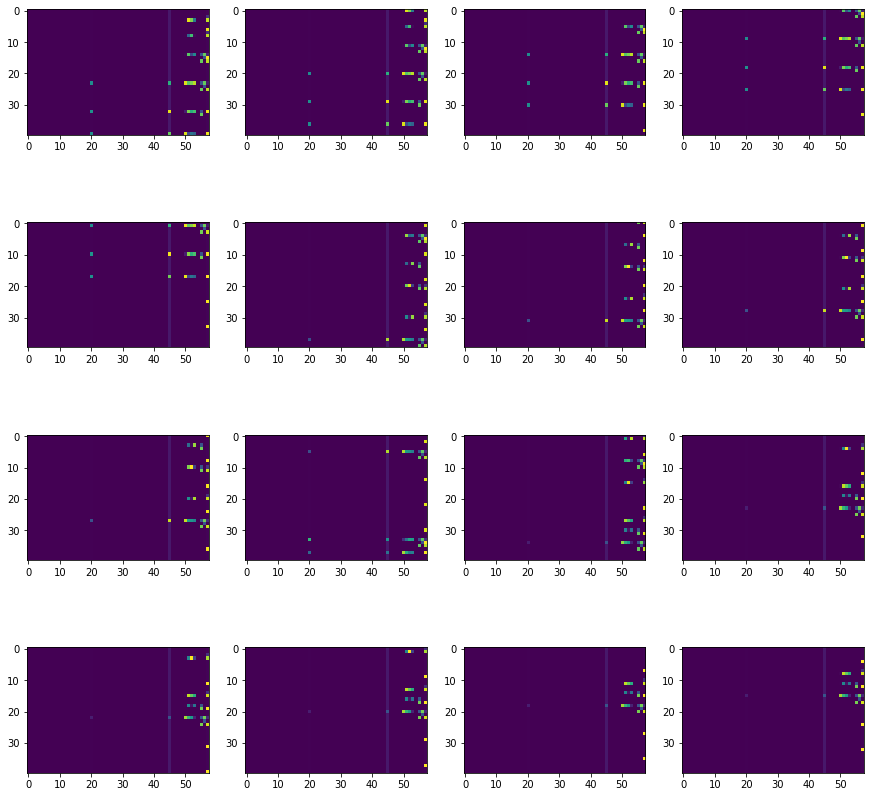

In [ ]:
plot_images(fold_0_X_test_anomalies)

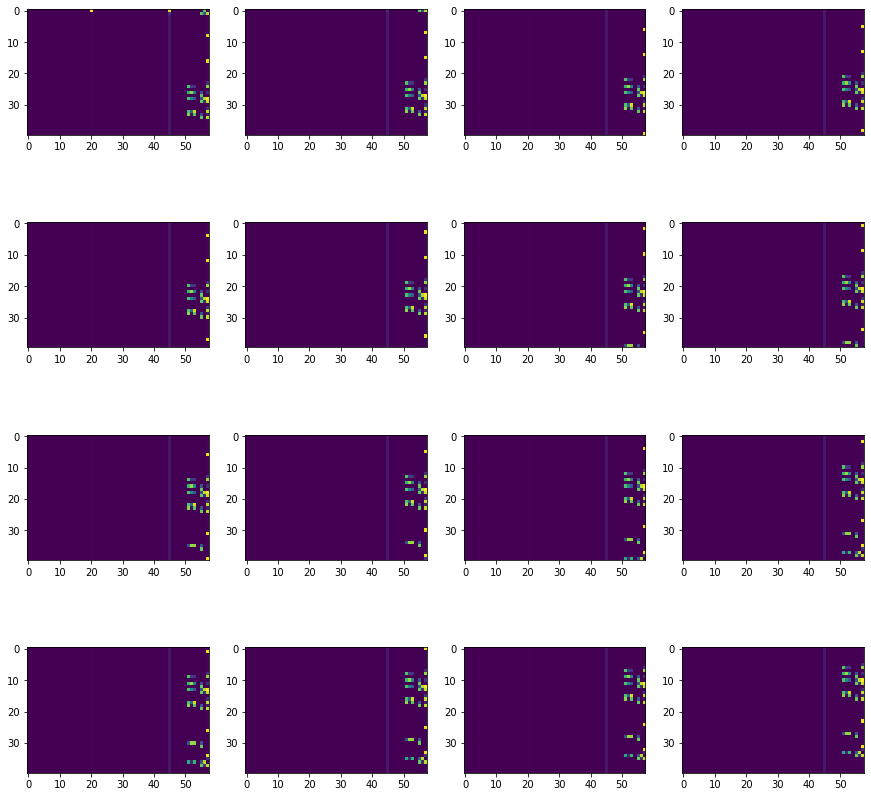

In [ ]:
plot_images(fold_0_X_normal_train)

## Window size = 44, N_cols=116

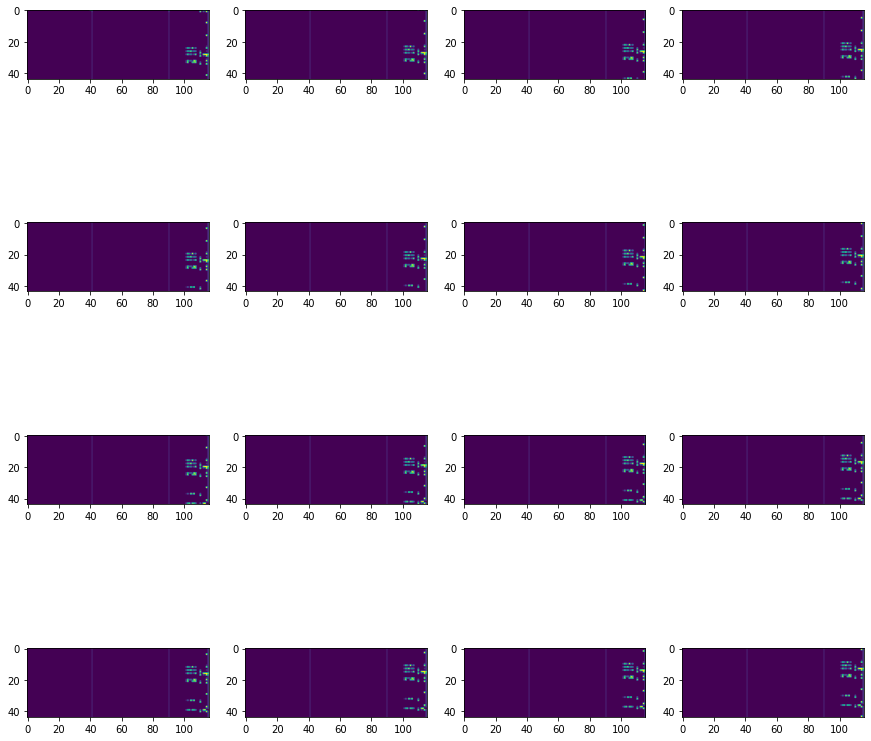

In [ ]:
plot_images(fold_0_X_normal_train, shape=(44, 116))

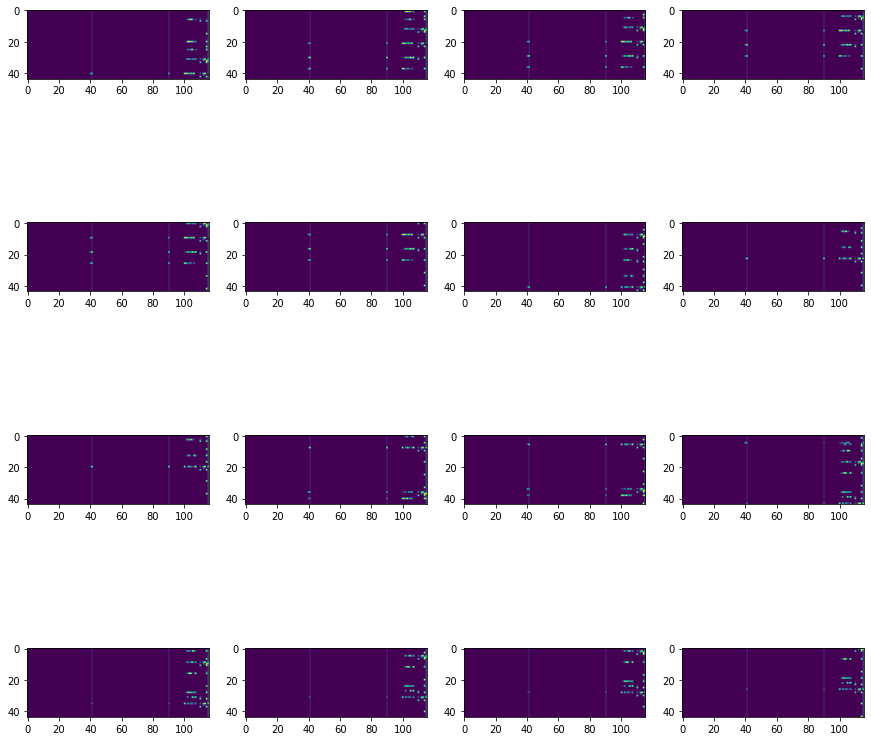

In [ ]:
plot_images(fold_0_X_test_anomalies, shape=(44, 116))